## Training a classification model using the TMC data

### Dependencies

In [1]:
import glob
import numpy as np
import os
import collections
import sys

import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt

import cv2
import imageio
import csv
from tifffile import TiffFile, imsave, imread, imwrite

import argparse
import yaml

%load_ext autoreload


### Constants

In [2]:
root_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files'
processed_data_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/ProcessedData'
raw_data_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/Data'
gt_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/ProcessedData/gt.pkl'
result_path = '/project/ahoover/mhealth/zeyut/tmc/results/'
# result_path = './results/'


Label2Numbers = {'Healthy': 0, 'Mid-Stage': 1, 'Late-Stage': 2}
Numbers2Labels = {0: 'Healthy', 1: 'Mid-Stage', 2: 'Late-Stage'}

gesture_list = ['Key Pinch', 'Stat Abd', 'Stat Add', 'Stat Ext', 'Stat Flex']

kinematic_channels = ['helical_angle',
             'helical_translation',
             'volar-dorsal_angle',
             'volar-dorsal_translation',
             'radial-ulnar_angle',
             'radial-ulnar_translation',
             'inferior-superior_angle',
             'inferior-superior_translation']
target_cycle_lens = {'Key Pinch': 11500,
                     'Stat Abd': 9000,
                     'Stat Add': 9200,
                     'Stat Ext': 9200,
                     'Stat Flex': 11500}
target_cycle_len = 12000
downsample_rate = 10
cv_configs = {'random_seed': 42,
              'num_splits': 5}

kinematic_model_configs = {'num_epochs': 5,
                           'batch_size': 32,
                           'beta': 0.9999,
                           'num_workers': 4,
                           'max_step': 50,
                           'patience': 3,
                           'learning_rate': 0.001}
image_model_configs = {'num_epochs': 20,
                        'batch_size': 4,
                        'max_step': 30,
                        'num_workers': 4,
                        'patience': 3,
                        'learning_rate': 0.003,
                        'seed_path': "/project/ahoover/mhealth/zeyut/tmc/pre_trained/swin_unetr_btcv_segmentation/models/model.pt"
                        }

configs = {'root_path': root_path,
           'raw_data_path': raw_data_path,
           'processed_data_path': processed_data_path,
           'gt_path': gt_path,
           'results_path': result_path,
           'Label2Numbers': Label2Numbers,
           'gesture_list': gesture_list,
           'kinematic_channels': kinematic_channels,
           'target_cycle_len': target_cycle_len,
           'downsample_rate': 10,
           'cv_configs': cv_configs,
           'kinematic_model_configs': kinematic_model_configs,
          'image_model_configs': image_model_configs}

with open(os.path.join(root_path, 'configs.yaml'), 'w') as file:
    yaml.dump(configs, file)

In [3]:
font = {'weight' : 'normal','size': 21}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

### Load data

#### Ground truth files

In [4]:
grades = {}
ages = {}

grades['new'] = {}
grades['old'] = {}
# # Load new scores
# grade_df = pd.read_excel(os.path.join(root_path, 'Supplements/Hand Groups.xlsx'))
# sample_codes = (grade_df.iloc[:, 0].tolist())
# for sc in sample_codes:
#     group = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == sc][0], 1]
#     grades['new'][sc] = Label2Numbers[group]
    
# Load new scores
grade_df = pd.read_excel(os.path.join(root_path, 'Supplements/all_results_clean_for_stats.xlsx'))
sample_codes = (grade_df.iloc[:, 0].tolist())
for sc in sample_codes:
    group = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == sc][0], 6]
    grades['new'][sc] = group
    
# Load old OA scores
old_grades = {}
grade_df = pd.read_excel(os.path.join(root_path, 'Supplements/all_results_clean_for_stats.xlsx'))
for sc in sample_codes:
    try:
        grades['old'][sc] = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == sc][0], 2]
        ages[sc] = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == sc][0], 1]
    except:
        print(f'Cannot find old grade for {sc}')
        del grades['new'][sc]
    

In [5]:
print(f'class size')
class_sizes_old = [collections.Counter(list(grades['old'].values())).get(i, 0) for i in range(5)]
class_sizes_new = [collections.Counter(list(grades['new'].values())).get(i, 0) for i in range(3)]
print(f"old_grades: {class_sizes_old}")
print(f"new_grades: {class_sizes_new}")

class size
old_grades: [7, 14, 15, 7, 3]
new_grades: [11, 25, 10]


In [16]:
if not os.path.exists(gt_path):
    with open(gt_path, 'wb') as file:
        pickle.dump(grades, file)

#### Processed kinematic data
* Calculated from motion and rigid body data 
* Processing script: kinematic_multiprocessing.py (Edited on 11/2024 by Daniel Gordon)
* subject H7, H8, H16, J2, J4, J8, J9 do not have kinematic data

In [7]:
raw_pkl_path = os.path.join(processed_data_path, 'kinematic_raw.pkl')
if os.path.exists(raw_pkl_path):
    with open(raw_pkl_path, 'rb') as file:
        kinematic_raw = pickle.load(file)
else:
    # Load raw data
    kinematic_raw = collections.defaultdict(dict)
    for sc in sample_codes:
        cur_path = os.path.join(root_path, f'ProcessingScripts/Results/{sc} Kinematic Results.xlsx')
        try:
            kinematic_sheets = pd.read_excel(cur_path, sheet_name=None)
            for sheet_name in kinematic_sheets.keys():
                gesture = sheet_name.split(sc)[1].strip()
                raw = kinematic_sheets[sheet_name].values
                kinematic_raw[sc][gesture] = kinematic_sheets[sheet_name].values
        except:
            print(f'Can not open {sc} kinematic result file')

    # Save data to pkl file to reduce loading time
    with open(raw_pkl_path, 'wb') as file:
        pickle.dump(kinematic_raw, file)

In [8]:
# Load start/end timestamps for each cycle 
cycles = collections.defaultdict(dict)
all_cycle_sheets = pd.read_excel(os.path.join(root_path, f'Supplements/Kinematic Cycles.xlsx'), sheet_name=None)
for sc in kinematic_raw:
    try:
        cycle_df = all_cycle_sheets[sc]
        for _, row in cycle_df.iterrows():
            gesture = row.iloc[0]
            cur_cycles = []
            for i, value in enumerate(row[1:]):  # skipping index
                if not pd.isna(value):
                    start_idx, end_idx = value.split(':')
                    cur_cycles.append([int(start_idx.strip()), int(end_idx.strip())])
            if cur_cycles:
                cycles[sc][gesture] = cur_cycles
    except:
        print(f'Can not find cycle info for {sc}')

# Remove those subjects that do not have all five gestures 
for sc in list(cycles.keys()):
    if len(cycles[sc]) != 5:
        print(sc)
        del cycles[sc]

H15
H19
H26
J5
J7


In [9]:
# Count maximum cycle length for each gesture
print('Max cycle length')
for sc in cycles:
    print(sc)
    all_lens = []
    for gesture in gesture_list:
        lens = [end-start for start, end in cycles[sc][gesture]]
        # print(f"{gesture} max: {np.max(lens)} avg: {np.mean(lens):.02f} cycle len: {lens}")    
    
        all_lens.append(max([end-start for start, end in cycles[sc][gesture]]))
    print(f'max cycle length per gesture: {all_lens}')

Max cycle length
H1
max cycle length per gesture: [793, 671, 740, 695, 1157]
H3
max cycle length per gesture: [327, 330, 224, 209, 246]
H4
max cycle length per gesture: [7372, 6921, 6629, 6921, 8679]
H5
max cycle length per gesture: [10320, 8391, 8280, 8885, 11332]
H9
max cycle length per gesture: [9264, 7816, 8011, 8317, 7113]
H10
max cycle length per gesture: [10547, 8189, 8306, 8312, 11432]
H11
max cycle length per gesture: [9398, 7509, 9157, 9115, 9520]
H12
max cycle length per gesture: [9246, 8640, 8000, 8607, 8518]
H13
max cycle length per gesture: [11429, 8117, 8234, 8120, 10721]
H14
max cycle length per gesture: [308, 384, 229, 376, 501]
H18
max cycle length per gesture: [7901, 8943, 7144, 7157, 9494]
H20
max cycle length per gesture: [352, 465, 468, 301, 473]
H21
max cycle length per gesture: [414, 382, 406, 388, 469]
H22
max cycle length per gesture: [219, 349, 301, 319, 382]
H23
max cycle length per gesture: [255, 324, 233, 181, 270]
H24
max cycle length per gesture: [283, 4

In [12]:
# Slice data within each cycle and save to files
kinematic_data = collections.defaultdict(dict)
for sc in kinematic_raw:
    if sc not in cycles:
        continue
    for gesture in kinematic_raw[sc]:
        if gesture not in cycles[sc]:
            continue
        data = kinematic_raw[sc][gesture]
        kinematic_data[sc][gesture] = []
        for start_idx, end_idx in cycles[sc][gesture]:
            kinematic_data[sc][gesture].append(data[start_idx: end_idx])

if not os.path.exists(os.path.join(processed_data_path, 'kinematic_data.pkl')):
    with open(os.path.join(processed_data_path, 'kinematic_data.pkl'), 'wb') as file:
        pickle.dump(kinematic_data, file)



In [19]:
kinematic_data.keys()

dict_keys(['H1', 'H3', 'H4', 'H5', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H18', 'H20', 'H21', 'H22', 'H23', 'H24', 'H25', 'H28', 'H29', 'H31', 'H32', 'H33', 'H34', 'H35', 'H36', 'H37', 'H38', 'H39', 'H40', 'J1', 'J3', 'J10', 'H19'])

In [35]:
kinematic_data[sc][gesture_list[0]][0].shape

(793, 8)

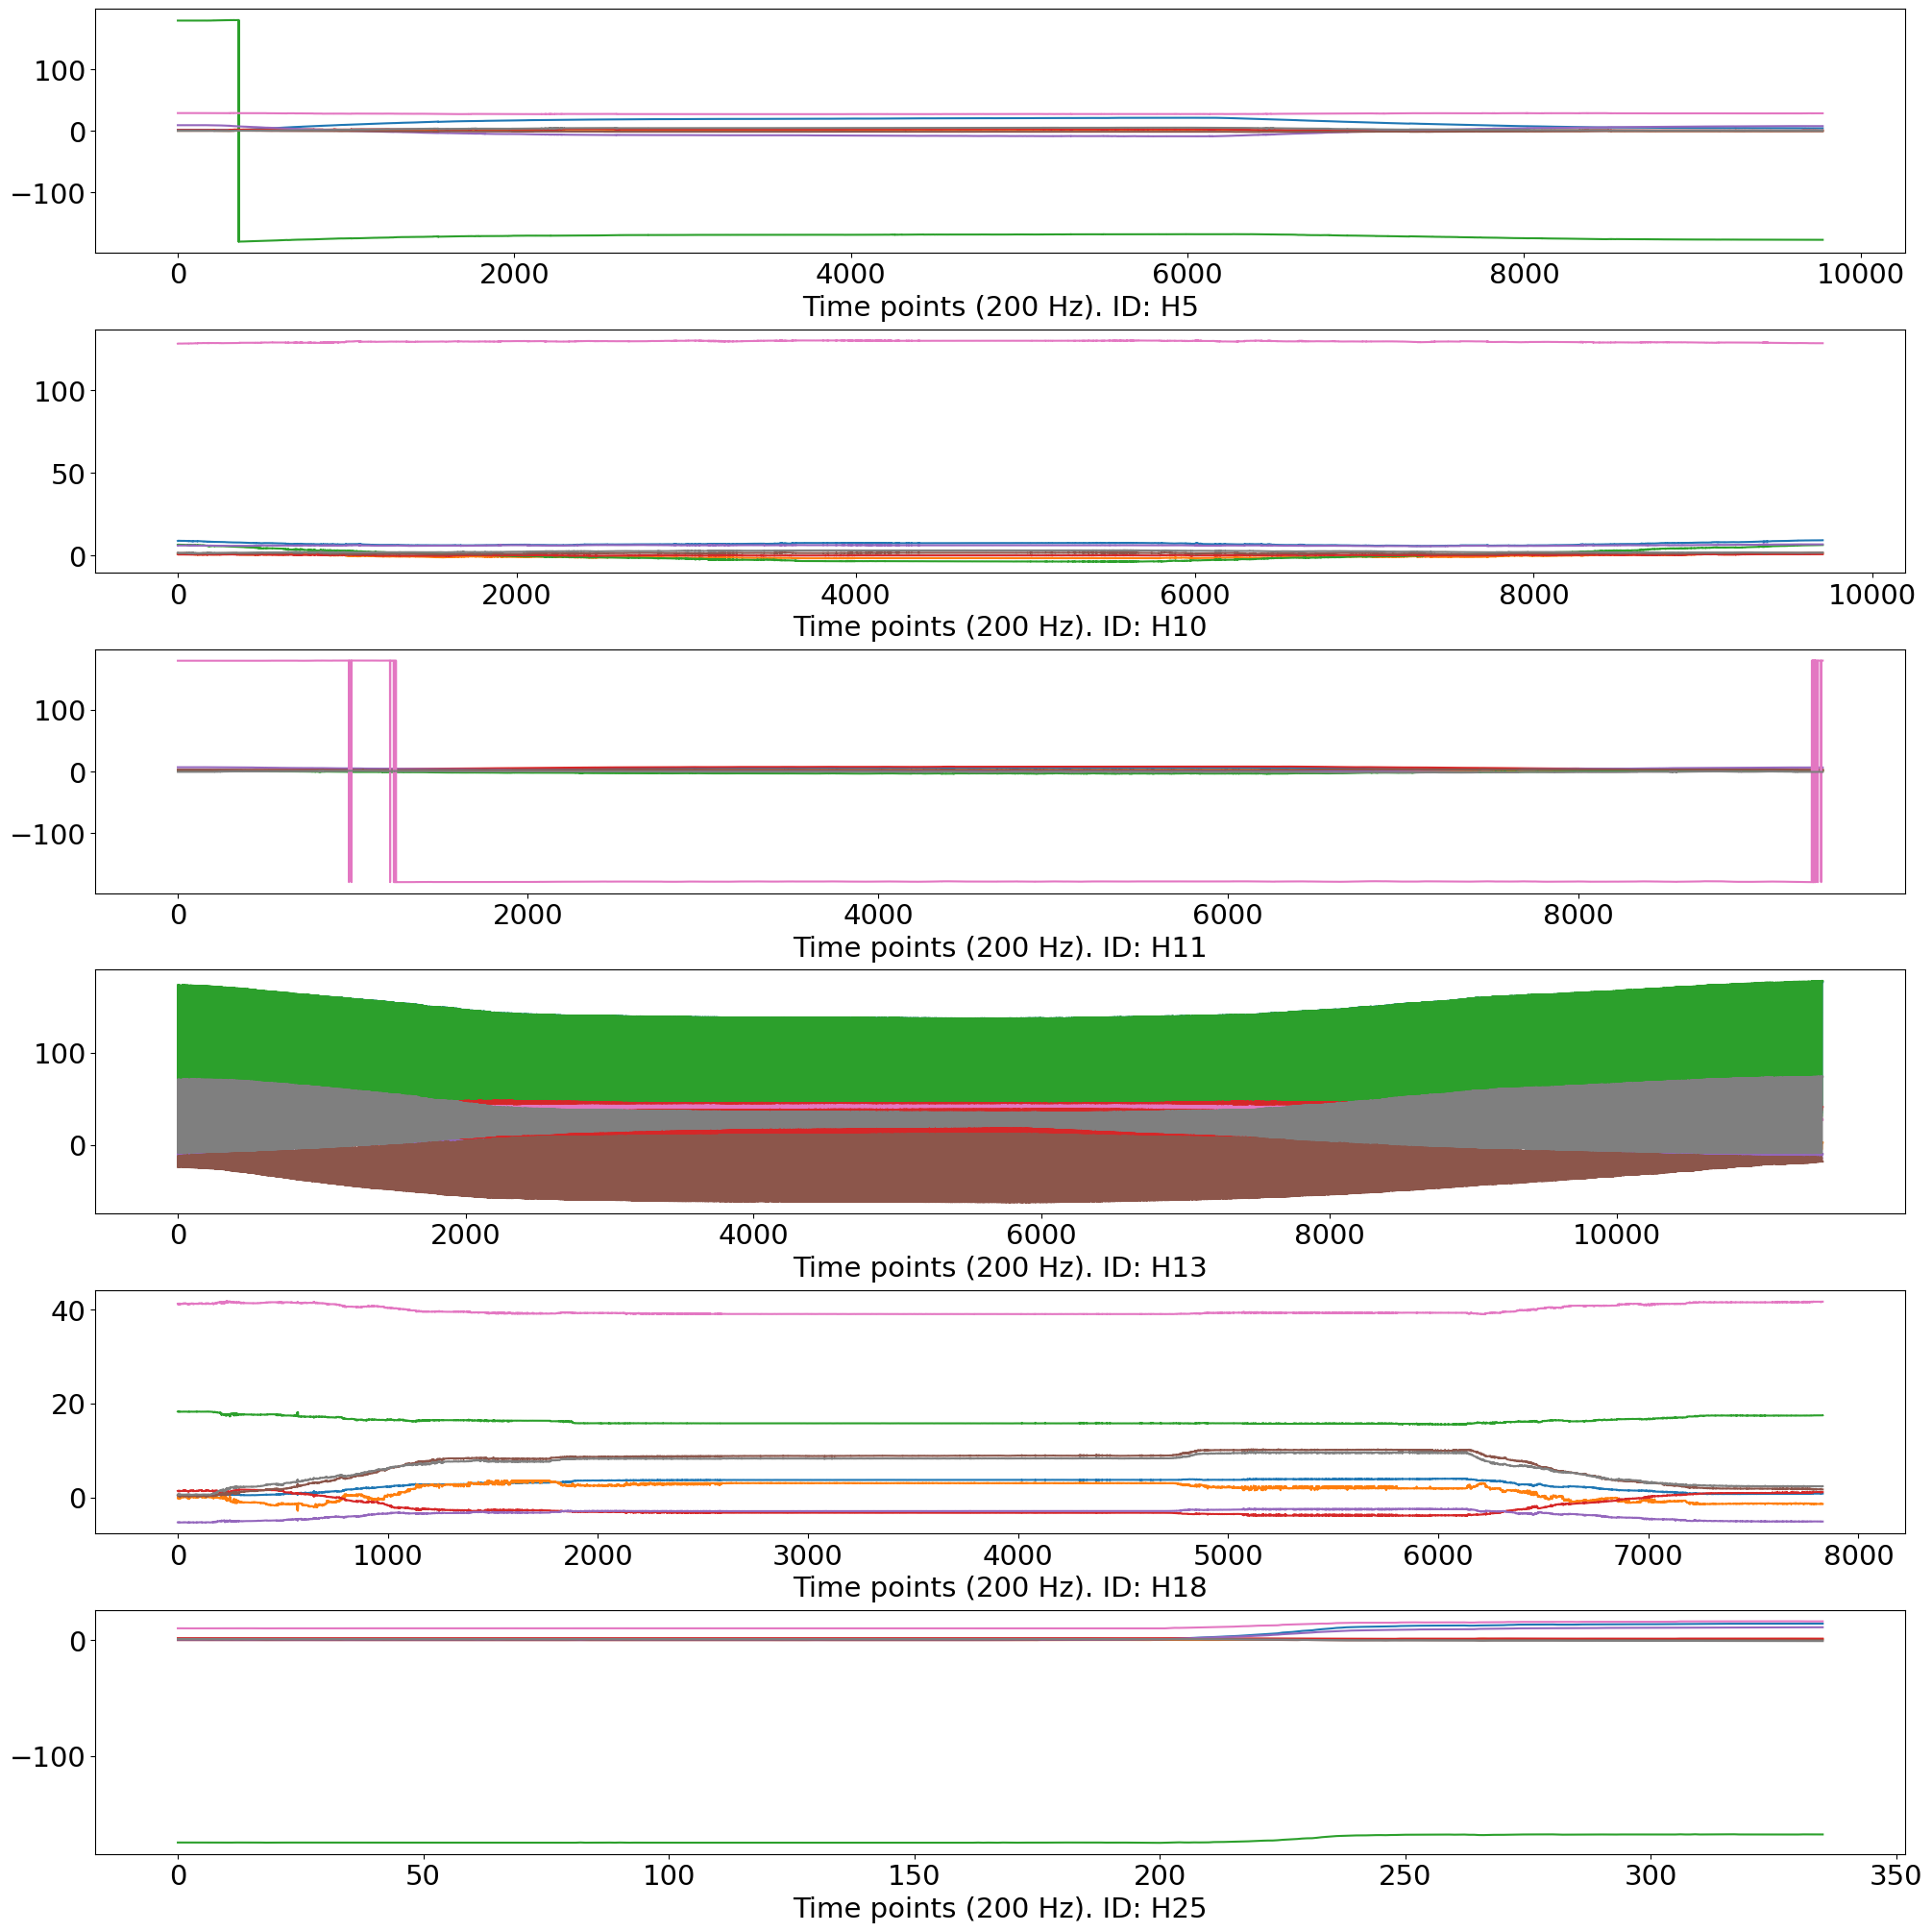

In [40]:
sc = 'J3'
fig, axs = plt.subplots(6, 1, 
                        figsize=(20, 20),
                        constrained_layout=True)
for i, sc in enumerate([key for key in kinematic_data if grades['new'].get(key, -1)==0]):
    for j in range(8):
        axs[i].plot(kinematic_data[sc][gesture_list[0]][0][:, j])
    axs[i].set_xlabel(f'Time points (200 Hz). ID: {sc}')
    if i >= 5:
        break
        
fig.savefig('class_0.jpg',dpi=300)

In [36]:
mean = []
std = []
for gesture in gesture_list:
    mean.append(np.mean(np.vstack([np.vstack(v[gesture]) for v in kinematic_data.values()]),axis=0))
    std.append(np.std(np.vstack([np.vstack(v[gesture]) for v in kinematic_data.values()]),axis=0))

In [37]:
std

[array([ 24.68050667,   2.05542705, 120.92328777,   8.51206906,
          9.83697987,   9.26287387,  80.49430528,   9.4006945 ]),
 array([ 24.4570863 ,   2.57981505, 120.58480345,   4.04779858,
         16.08127936,   4.50588822,  75.02620711,  13.06893166]),
 array([ 20.95788073,   3.05498723, 116.50273351,   6.41242108,
         13.56749622,   6.43618958,  82.77430517,  11.42619864]),
 array([ 29.77843322,   5.54253412, 114.86867905,  15.63156633,
         21.9643887 ,  10.95828284,  89.98362301,  14.74653418]),
 array([ 28.58102941,   7.16316   , 111.17806371,  12.84539873,
         30.91876887,  13.80616513,  67.59780561,  19.47213079])]

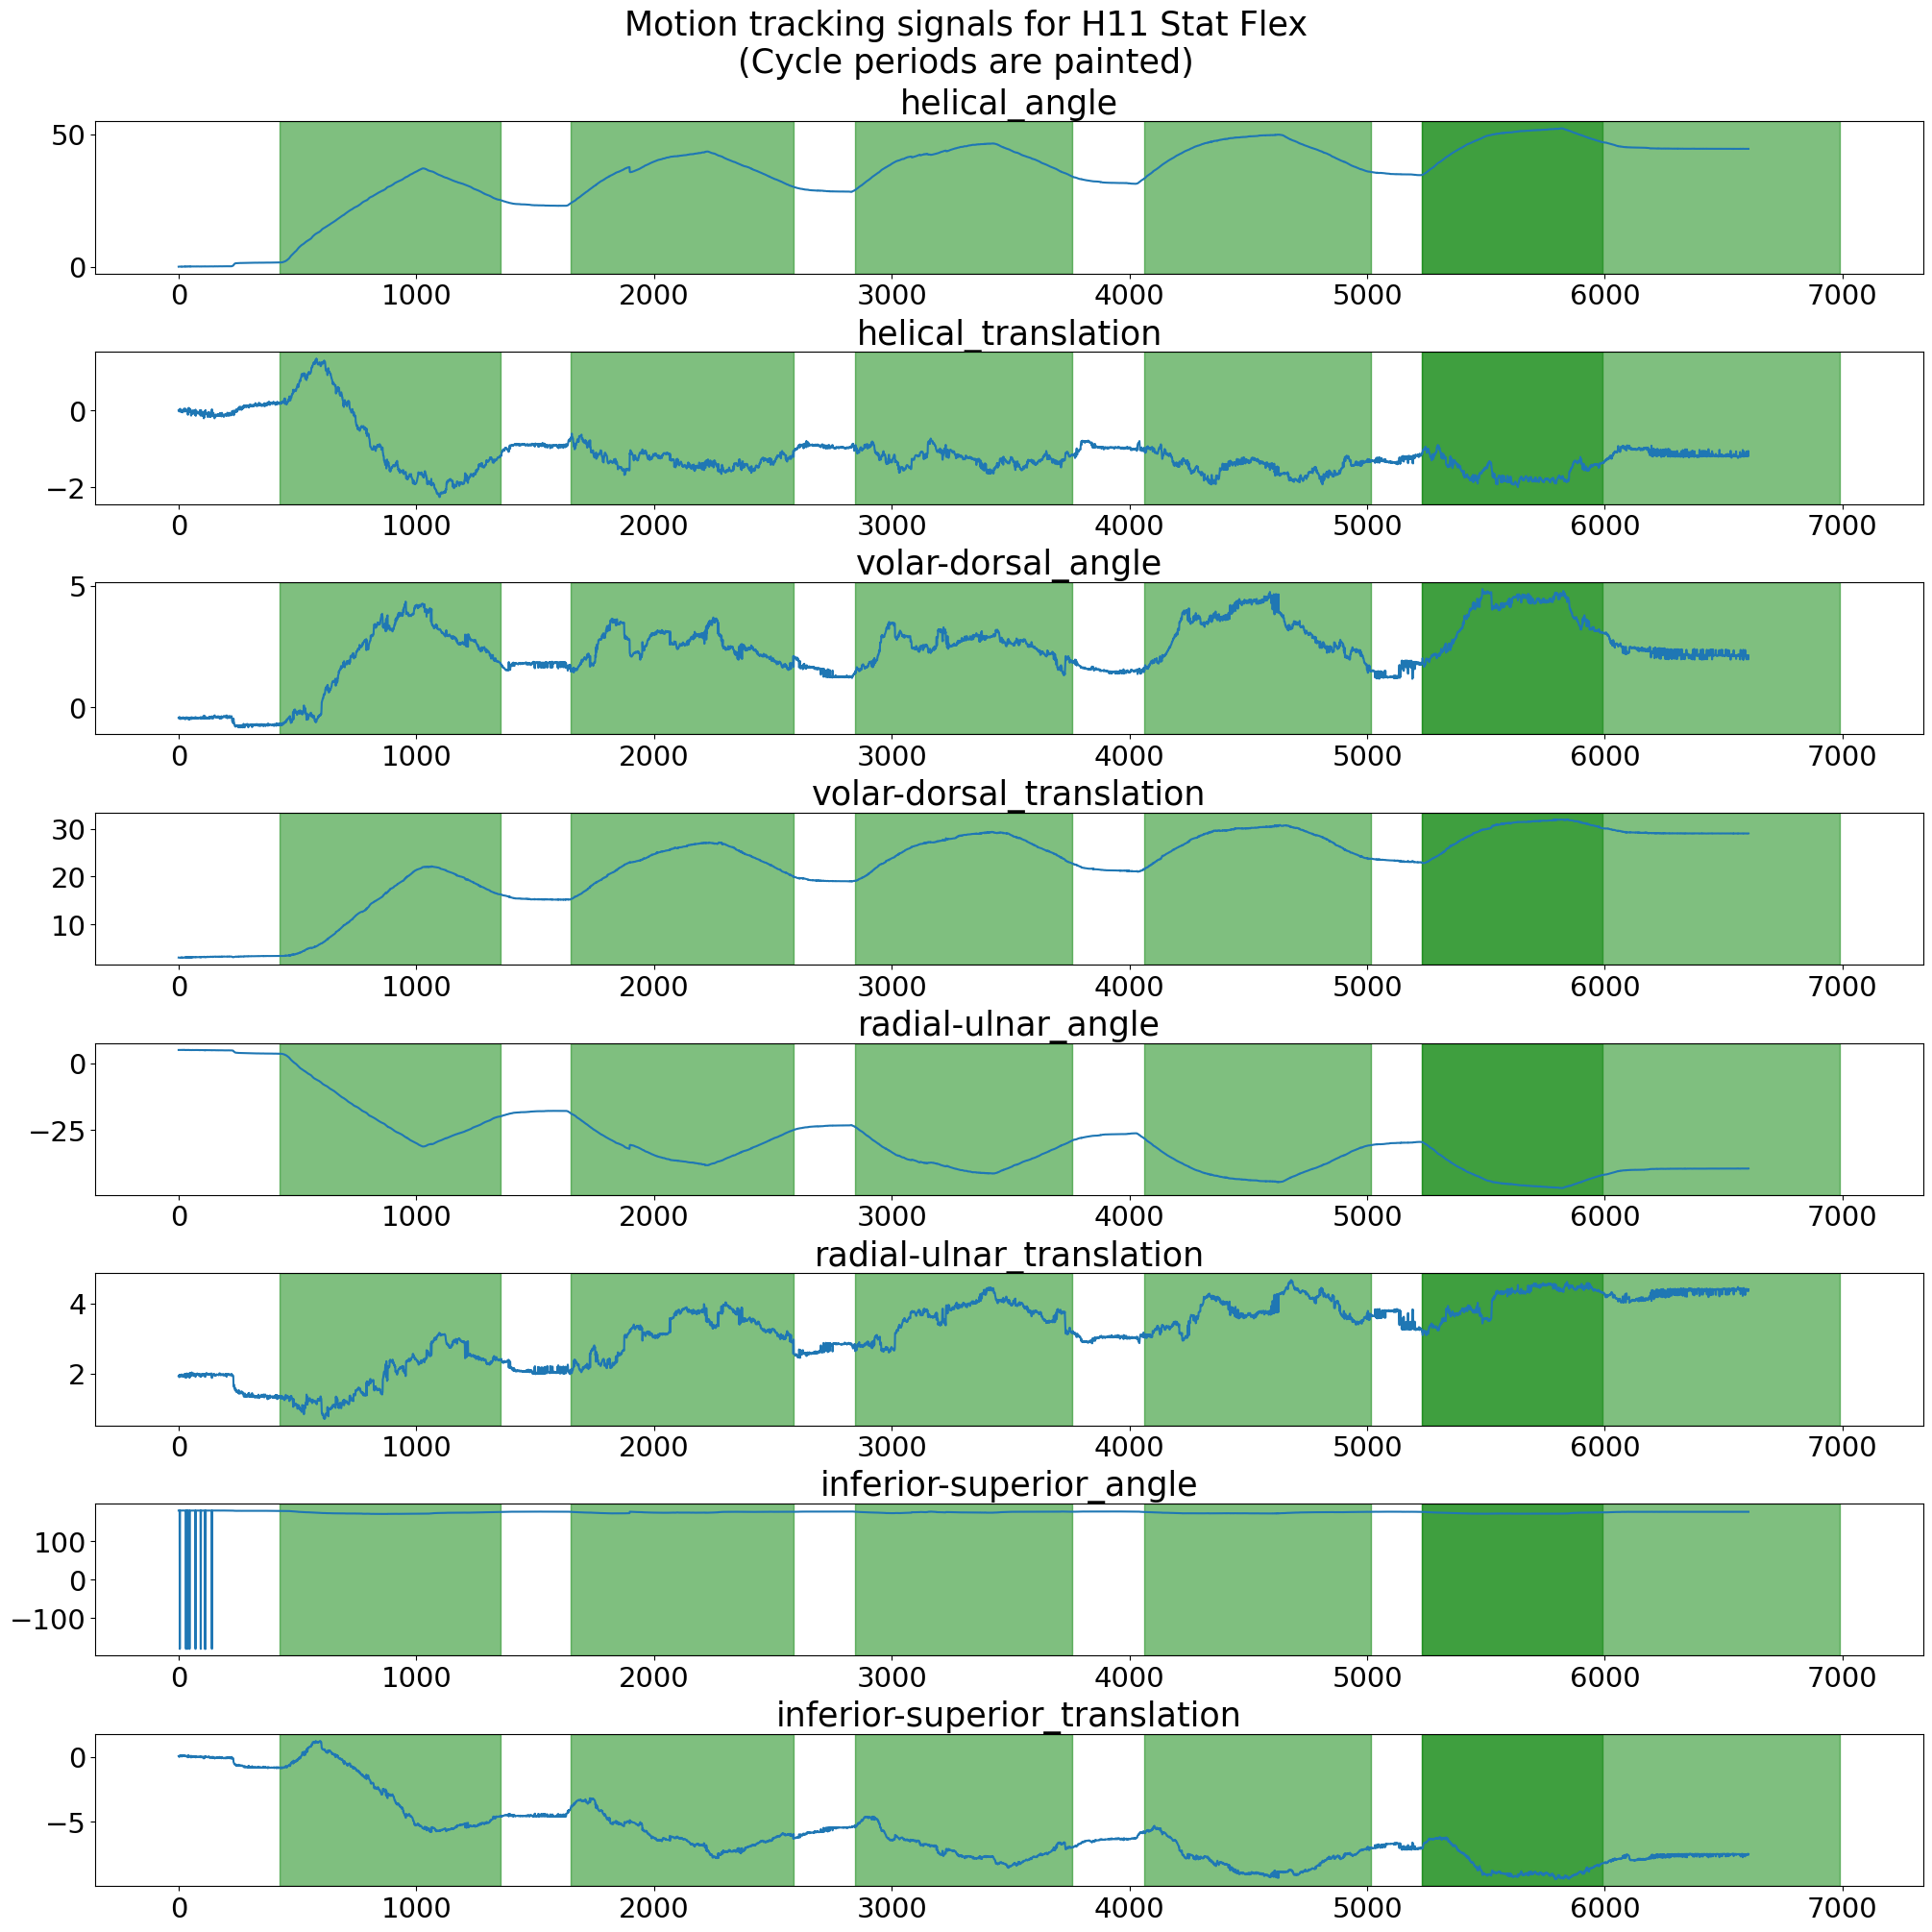

In [56]:
# Visualize data 
sc = 'H11'
gesture = 'Stat Flex'
downsample_rate = 10
fig, axs = plt.subplots(8, 1, 
                        figsize=(20, 20),
                        constrained_layout=True)
for i in range(8):
    axs[i].plot(kinematic_raw[sc][gesture][::downsample_rate, i])
    axs[i].set_title(kinematic_channels[i])
    for start_idx, end_idx in cycles[sc][gesture]:
        axs[i].axvspan(start_idx//downsample_rate, end_idx//downsample_rate, color='g', alpha=0.5, label='cycles')
    axs[i].axvspan(start_idx//downsample_rate, (end_idx+10000)//downsample_rate, color='g', alpha=0.5, label='cycles')
fig.suptitle(f'Motion tracking signals for {sc} {gesture}\n(Cycle periods are painted)')    
plt.show()
fig.savefig('time_series.jpg', dpi=600)

#### Static data 
* Include kinematic indices from motion tracking data and mechanical/dimensional measurements
* Select sample codes which have data available on all types

In [13]:
static_data = collections.defaultdict(list)

'''
Data drieved from dynamic measurement
    File: all_results_clean_for_stats.xlsx 
    Use sheet 'bony' and 'kinm', sheet 'mech' has many empty cells.

'''
static_sheets = pd.read_excel(os.path.join(root_path, f'Supplements/all_results_clean_for_stats.xlsx'), sheet_name=None)
for sheet_name in ['bony', 'kinm']:
    static_df = static_sheets[sheet_name]
    n_rows = len(static_df.iloc[0])
    static_df.dropna(thresh=n_rows//2, inplace=True) # Drop rows with more than half cells being nan
    sc_list = static_df.iloc[:, 0].values
    static_df = static_df.drop(columns=static_df.columns[:7]) # Leave numeric data only
    static_df.fillna(static_df.mean(), inplace=True) # Fill empty values with column average
    for sc, data in zip(sc_list, static_df.values):
        static_data[sc].append(data)

In [14]:
'''
Data drieved from mechanical measurement
    File: Ligament_Dimensions_Squash.xlsx, Cartilage_Data_Squash.xlsx
    Use Ligament_Dimensions_Squash.xlsx only. Cartilage_Data_Squash.xlsx has many empty cells

'''
ligament_df = pd.read_excel(os.path.join(root_path, f'Supplements/Ligament_Dimensions_Squash.xlsx'))
ligament_df.drop([0,1], inplace=True) # Drop irrelevant rows
n_rows = len(ligament_df.iloc[0])
# Decide not to drop rows here, becaue I want to keep all valid dynamic measurement, which covers the majority of static indices.
# ligament_df = ligament_df[np.sum(ligament_df==0, axis=1)<=n_rows//2] # Drop rows with more than half cells being 0
sc_list = ligament_df.iloc[:, 1].values
ligament_df = ligament_df.drop(columns=ligament_df.columns[0:2]) # Leave numeric data only
means = ligament_df.replace(0, np.nan).mean()
ligament_df = ligament_df.replace(0, means) # Fill the rest of zeros with column averages
for sc, data in zip(sc_list, ligament_df.values):
    static_data[sc].append(data)



In [15]:
# Remove sample codes that miss any type of static data
for sc in list(static_data.keys()):
    if len(static_data[sc]) < 3:
        print(sc)
        del static_data[sc]

H7
H14
H15
H16
H17
H25
J2
J6
J8
J9
H2
H22
H37
H8
J4


In [16]:
if not os.path.exists(os.path.join(processed_data_path, 'static_data.pkl')):
    with open(os.path.join(processed_data_path, 'static_data.pkl'), 'wb') as file:
        pickle.dump(static_data, file)

#### Image data

In [17]:
image_sc = []
for sc in sample_codes:
    image_list = glob.glob(os.path.join(root_path, f"Data/{sc}/BonyGeometry/DICOMs/CT*/*.IMA"))
    if len(image_list) > 0:
        image_sc.append(sc)

print(f'#image samples: {len(image_sc)}')

#image samples: 43


In [18]:
# Load bounding boxs
for sc in sample_codes:
    label_path = os.path.join(root_path, f"CT Labelling/{sc} Labels.tif")
    if os.path.exists(label_path):
        label_img = imread(label_path)
    else:
        print(f'cannot find labels for {sc}')
    # break

cannot find labels for H8
cannot find labels for H17
cannot find labels for H21
cannot find labels for H35
cannot find labels for H36
cannot find labels for J4


In [19]:
label_img = imread(os.path.join(root_path, f"CT Labelling/J9 Labels.tif"))


In [21]:
root_path

'/project/ahoover/mhealth/zeyut/tmc/TMC AI Files'

In [12]:
with open(os.path.join(processed_data_path, f'images/H16.pkl'), 'rb') as file:
    img = pickle.load(file)

In [13]:
# Save data to pkl file to reduce loading time
max_ = 0
min_ = float('inf')
if True:
    for sc in sample_codes:
        image_paths = sorted(glob.glob(os.path.join(root_path, f"Data/{sc}/BonyGeometry/DICOMs/CT*/*.IMA")))  
        image_pkl_path = os.path.join(processed_data_path, f'images/{sc}.pkl')
        os.makedirs(os.path.join(processed_data_path,'images'), exist_ok=True)
        try:
            with open(image_pkl_path, 'rb') as file:
                img = pickle.load(file)
        except:
            cur_vol = np.zeros((512, 512, 512))
            for i, slice_file in enumerate(image_paths):
                if i >= 512:
                    break  # Avoid reading more slices than the target depth
                image = imageio.v2.imread(slice_file).astype(np.float32) 
                if image.shape != (512,512):
                    print(sc, image.shape)
                cur_vol[i, :, :] = image
                max_ = max(max_, np.max(cur_vol))
                min_ = min(min_, np.min(cur_vol))
            with open(image_pkl_path, 'wb') as file:
                pickle.dump(cur_vol, file)
            print(sc)

H3
H13
H14
H18


In [19]:
max_, min_

((), ())

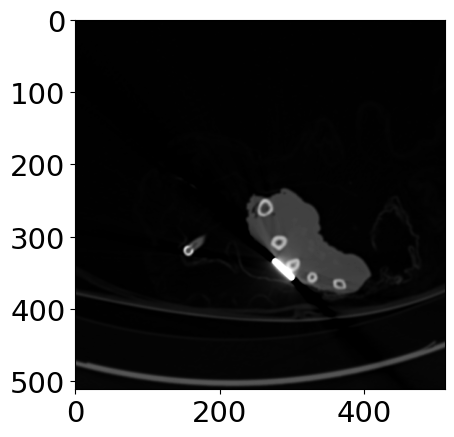

In [13]:
plt.imshow(image,cmap='gray')

In [ ]:
# Visualize data
sc = 'H1'
image_list = glob.glob(f"/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/Data/{sc}/BonyGeometry/DICOMs/CT/*.IMA")

cols = 4
rows = 2
fig, axs = plt.subplots(rows, cols,
                        figsize=(30, 20))
for r in range(rows):
    for c in range(cols):
        image = imageio.v2.imread(image_list[r*4+c])
        normalized = cv2.normalize(
                    image, None, 
                    alpha=0, beta=255, 
                    norm_type=cv2.NORM_MINMAX)
        axs[r, c].imshow(normalized, cmap='gray')
        axs[r, c].axes.get_xaxis().set_visible(False)
        axs[r, c].axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
plt.tight_layout() 

fig.savefig('CT_images.pdf', dpi=300)

In [ ]:
old_grades['J10'] = 1

In [ ]:
sorted(collections.Counter([old_grades[sc] for sc in sample_codes]))

#### Count Class sizes

In [ ]:
combs = ['static', 'kinematic', 'image', 'kinematic+static', 'image+static', 'image+kinematic', 'all']
for i, sc_list in enumerate([list(set(static_data.keys())), 
                list(set(kinematic_data.keys())),
                list(set(image_sc)),
                list(set(kinematic_data.keys()) & set(static_data.keys())),
                list(set(image_sc) & set(static_data.keys())),
                list(set(image_sc) & set(kinematic_data.keys())),
                list(set(image_sc) & set(static_data.keys()) & set(kinematic_data.keys()))]):
    print(combs[i])
    print(f'#samples: {len(sc_list)}')
    old_count = collections.Counter([grades['old'][sc] for sc in sc_list])
    new_count = collections.Counter([grades['new'][sc] for sc in sc_list])
    print(f'class size (old grading): {[old_count.get(i, 0) for i in range(5)]}')
    print(f'class size (new grading): {[new_count.get(i, 0) for i in range(3)]}')
    print('\n')